# Лабораторная работа 2
#### Цель работы: познакомиться с методом кластеризации K-mean с помощью пакета sklearn.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('autoscout24-germany-dataset.csv')
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.describe()

#### Добавим к датасету новый аттрибут - возраст автомобиля [car_age].

In [2]:
from datetime import date

current_year = date.today().year

df['car_age'] = df.apply(lambda row: current_year - row['year'], axis=1)
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year,auto_age
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011,12
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011,12
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011,12
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011,12
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011,12


### Очищаем выборку данных, убирая пропущенные значения и выбросы.

#### Поиск и удаление пропущенных значений

Столбец [model] содержит 143 пропущенных значения, то в зависимости от поставленной задачи мы можем удалить эти строки.
Та же самая ситуация касается типа коробки передач [gear].
Также 29 пропущенных значений было найдено в аттрибуте hp. В данном случае замена пропущенных значений средним, медианой или модой — грубый способ работы с ними. Такая аппроксимация, возможно, не приемлема и не даст удовлетворительные результаты. Но в связи с тем, что пропущенных данных достаточно мало относительно всех, то можно заменить, например, медианой.

После того, как мы убрали пропущенные значения в столбцах [gear] и [model], в столбце hp осталось 24 пропущенных значения.

---
Обоснование и поиск пропущенных значений было взято из лабораторной работы 1.


In [4]:
df.dropna(subset=['gear', 'model'], inplace=True)
df['hp'] = df['hp'].fillna(df['hp'].mode()[0])
df.isna().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
year         0
auto_age     0
dtype: int64

#### Подсчитаем количество дубликатов и удалим их

In [5]:
quantity_rows_before_deletion = df.shape[0]
df.drop_duplicates()
quantity_rows_after_deletion = df.shape[0]
if quantity_rows_before_deletion == quantity_rows_after_deletion:
    print("Дубликатов не найдено")
else:
    print(f"Количество удаленных дубликатов {quantity_rows_after_deletion - quantity_rows_before_deletion}")

Дубликатов не найдено


#### Поиск и удаление выбросов
Не существует строгого и однозначного правила насчет того, следует ли удалять выбросы из набора данных перед проведением статистического анализа. Довольно часто переменные значения, вызванные экспериментальной ошибкой или ошибкой измерения удаляются или заменяются на новые значения. Некоторые статистические тесты требуют их отсутствия, чтобы сделать обоснованные выводы, но удаление выбросов рекомендуется не во всех случаях и должно выполняться с осторожностью.

Для того, чтобы определить, является ли точка выбросом необходим контекст. Например, в Петербурге +15 градусов Цельсия. Зимой такая температура является выбросом, а летом нет.

In [6]:
# Избавимся от столбцов, содержащих НЕ числа
# axis=1 - по всем строкам

numeric_attrs = ['mileage','price','hp','car_age']
df_numeric = df.filter(numeric_attrs, axis=1)
print(f"Размер df_numeric = {df_numeric.shape}")
df_numeric.head()


Размер df_numeric = (46095, 4)


,mileage,price,hp,auto_age
0,235000,6800,116.0,12
1,92800,6877,122.0,12
2,149300,6900,160.0,12
3,96200,6950,110.0,12
4,156000,6950,156.0,12


Text(0.5, 0, 'Attributes')

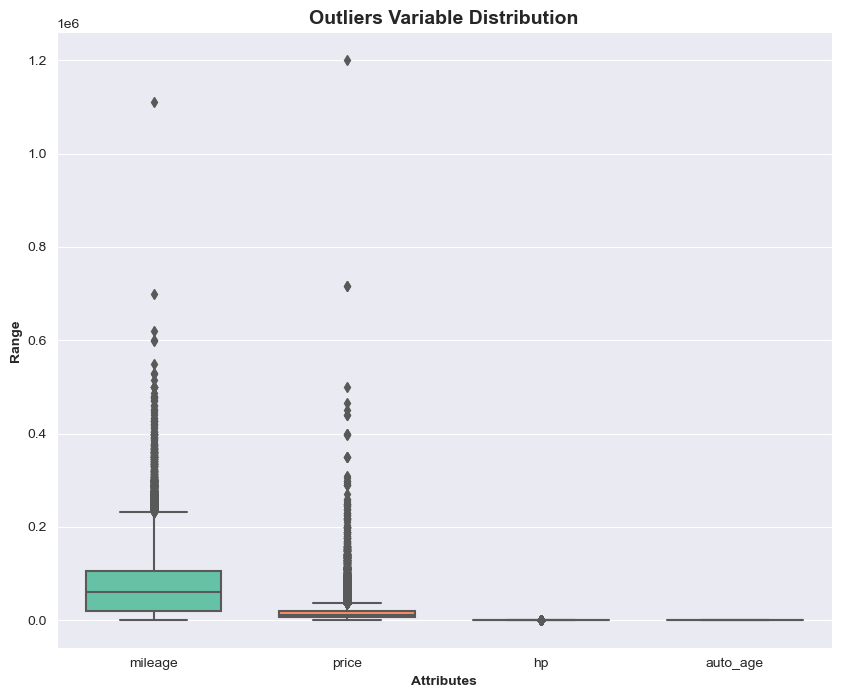

In [7]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_numeric[numeric_attrs], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [15]:
# Удаление выбросов для [mileage]
Q1 = df_numeric.mileage.quantile(0.05)
Q3 = df_numeric.mileage.quantile(0.95)
IQR = Q3 - Q1
df_numeric = df_numeric[(df_numeric.mileage >= Q1 - 1.5 * IQR) & (df_numeric.mileage <= Q3 + 1.5 * IQR)]

# Удаление выбросов для [price]
Q1 = df_numeric.price.quantile(0.05)
Q3 = df_numeric.price.quantile(0.95)
IQR = Q3 - Q1
df_numeric = df_numeric[(df_numeric.price >= Q1 - 1.5 * IQR) & (df_numeric.price <= Q3 + 1.5 * IQR)]

# Удаление выбросов для [hp]
Q1 = df_numeric.hp.quantile(0.05)
Q3 = df_numeric.hp.quantile(0.95)
IQR = Q3 - Q1
df_numeric = df_numeric[(df_numeric.hp >= Q1 - 1.5 * IQR) & (df_numeric.hp <= Q3 + 1.5 * IQR)]

# Удаление выбросов для [car_age]
Q1 = df_numeric.car_age.quantile(0.05)
Q3 = df_numeric.car_age.quantile(0.95)
IQR = Q3 - Q1
df_numeric = df_numeric[(df_numeric.car_age >= Q1 - 1.5 * IQR) & (df_numeric.car_age <= Q3 + 1.5 * IQR)]

print(f"Размер df_numeric после удаления выбросов= {df_numeric.shape}")

Размер df_numeric после удаления выбросов= (45673, 4)


### Построение графиков зависимости одной переменной от другой

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
"""
    аргумент [hue] подсвечивает указанную категорию другим цветом.
"""
sns.pairplot(df,hue='gear')

#### Диаграмма рассеяния
[Статья про построение диаграмм на хабре](https://habr.com/ru/companies/skillfactory/articles/664756/)
Диаграмма рассеяния показывает взаимосвязь между двумя числовыми признаками с помощью точек, показывающих движение этих переменных вместе.

In [ ]:
sns.set(font_scale=1.3)
sns.scatterplot(
    x='hp',
    y='mileage',
    data=df,
    hue='gear')
plt.xlabel(
    'horsepower')
plt.ylabel(
    'mileage')

In [ ]:
sns.set(font_scale=1.3)
sns.scatterplot(
    x='car_age',
    y='mileage',
    data=df,
    hue='gear')
plt.xlabel(
    'car_age')
plt.ylabel(
    'mileage')

### Кластеризация данных
[Кластеризация данных](https://logic.pdmi.ras.ru/~yura/internet/02ia-seminar-note.pdf)
Кластеризация - это разбиение элементов некоторого множества на группы в зависимости от их схожести.
Кластеризация данных включает в себя следующие этапы:
1. Выделение характеристик.
Для начала необходимо выбрать свойства, которые характеризуют наши объекты. Ими могут быть количественные характеристики (координаты, интервалы.), качественные характеристики (цвет, статус, воинское звание...).
2. Определение метрики
Следующим этапом кластеризации является выбор метрики, по которой мы будем определять длизость объектов.
Метрика выбирается в зависимости от:
    1. пространства, в котором расположены объекты
    2. неявных характеристик кластеров
3. Разбиение объектов на группы
4. Представление результатов


### Алгоритм kMeans
Статьи:
[Алгоритм kMeans](https://logic.pdmi.ras.ru/~yura/internet/02ia-seminar-note.pdf)
[Алгоритм kMeans](https://logic.pdmi.ras.ru/~yura/internet/02ia-seminar-note.pdf)
[Кластеризация: алгоритмы k-means и c-means](https://habr.com/ru/articles/67078/)
[Алгоритм k средних (k-means)](https://algowiki-project.org/ru/Алгоритм_k_средних_(k-means))

Наиболее простой, но в то же время достаточно неточный метод кластеризации в классической реализации. Он разбивает множество элементов векторного пространства на заранее известное число кластеров k. Действие алгоритма таково, что он стремится минимизировать среднеквадратичное отклонение на точках каждого кластера. Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Алгоритм завершается, когда на какой-то итерации не происходит изменения кластеров.

Существует ряд проблем при использовании kmeans, о которых описано в источниках, приведенных выше.

#### Применение алгоритма на основе [notebook'a](https://www.kaggl.com/code/karthickaravindan/k-means-clustering-project/notebook)
Во время реализации алгоритма будет использована библиотека scikit-learn.
scikit-learn - библиотека, предназначенная для машинного обучения, написанная на языке программирования Python и распространяемая в виде свободного программного обеспечения.


##### Нормализация данных
Нормализация — это метод, который часто применяется как часть подготовки данных для машинного обучения. Цель нормализации — изменить значения числовых столбцов в наборе данных для использования общей шкалы без искажения различий в диапазонах значений или потери информации.

In [8]:
from sklearn import preprocessing

In [9]:
minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric)

In [10]:
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=numeric_attrs)
df_numeric_scaled.head()

,mileage,price,hp,auto_age
0,0.21150,0.004755,0.135453,1.0
1,0.08352,0.004819,0.142521,1.0
2,0.13437,0.004838,0.187279,1.0
3,0.08658,0.004880,0.128386,1.0
4,0.14040,0.004880,0.182568,1.0


##### Применение kMeans
Существует несколько методов определения количества кластеров. Воспользуемся Elbow method.

In [23]:
from sklearn.cluster import KMeans

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

In [ ]:
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(df_numeric_scaled)

In [ ]:
import numpy as np
import seaborn as sns

print(f"kmeans.labels_ = {kmeans.labels_}")
print(f"kmeans.cluster_centers_ = {kmeans.cluster_centers_}")
print(f"kmeans = {kmeans}")

In [ ]:
df_numeric['cluster'] = kmeans.labels_
df_numeric.head()

In [ ]:
import numpy as np

plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,15,1),y=df_numeric.groupby(['cluster']).count()['price'].values)
x=axis.set_xlabel("Cluster Number")
y=axis.set_ylabel("Cars")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

labels = kmeans.labels_

LABEL_COLOR_MAP = {0 :'#1f77b4',
                   1 :'#ff7f0e',
                   2 :'#2ca02c',
                   3 :'#d62728',
                   4 :'#9467bd',
                   5 :'#8c564b',
                   6 :'#e377c2',
                   7 :'#7f7f7f',
                   8 :'#bcbd22',
                   9 :'#17becf',
                   10 :'#000000',
                   11 :'#83d6a7',
                   12 :'#070094',
                   13 :'#940065',
                   14 :'#ffee00'}

label_color = [LABEL_COLOR_MAP[l] for l in labels]

plt.scatter(df_numeric.iloc[:,0], df_numeric.iloc[:,1], c=label_color)
plt.show()